<a href="https://colab.research.google.com/github/H0r0sho/lab5/blob/master/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import io
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cpu"

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data.csv")

In [ ]:
df.columns = ['date', 'value']  

nan_value = 0                              
df.replace(" ", nan_value, inplace=True)
df = df.dropna()
df_save = df
print(df)

           date    value
0    2022-10-21  61.5018
1    2022-10-20  61.5905
2    2022-10-19  61.7032
3    2022-10-18  61.7634
4    2022-10-15  63.0558
..          ...      ...
576  2020-06-30  69.9513
577  2020-06-27  69.1284
578  2020-06-26  69.4660
579  2020-06-25  68.8376
580  2020-06-24  68.8376

[581 rows x 2 columns]


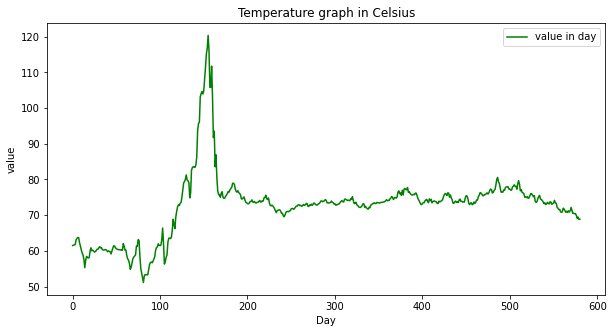

In [ ]:

import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(10, 5))
plt.title("Temperature graph in Celsius")    # Temperature graph in Celsius
plt.xlabel("Day")
plt.ylabel("value")
plt.plot(df['value'], color="green")
plt.legend(["value in day"])
plt.show()

In [ ]:
df = df.set_index(['date'])

df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic_increasing:
    df = df.sort_index()

In [ ]:
def generate_time_lags(df: pd.DataFrame, n_lags: int) -> pd.DataFrame:
    """the function of generating observations with a time delay"""
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n['value'].shift(n) #shift метод для сдвига значенией в столбце
    df_n = df_n.iloc[n_lags:]
    return df_n

input_dim = 100

df_timelags = generate_time_lags(df, input_dim)
print(df_timelags)

              value     lag1     lag2     lag3     lag4     lag5     lag6  \
date                                                                        
2020-11-12  76.2075  76.3978  76.9515  77.1875  78.4559  80.0006  80.5749   
2020-11-13  77.1148  76.2075  76.3978  76.9515  77.1875  78.4559  80.0006   
2020-11-14  77.3262  77.1148  76.2075  76.3978  76.9515  77.1875  78.4559   
2020-11-17  76.9197  77.3262  77.1148  76.2075  76.3978  76.9515  77.1875   
2020-11-18  76.2530  76.9197  77.3262  77.1148  76.2075  76.3978  76.9515   
...             ...      ...      ...      ...      ...      ...      ...   
2022-10-15  63.0558  63.4917  63.7559  63.6840  62.3126  61.2475  60.2534   
2022-10-18  61.7634  63.0558  63.4917  63.7559  63.6840  62.3126  61.2475   
2022-10-19  61.7032  61.7634  63.0558  63.4917  63.7559  63.6840  62.3126   
2022-10-20  61.5905  61.7032  61.7634  63.0558  63.4917  63.7559  63.6840   
2022-10-21  61.5018  61.5905  61.7032  61.7634  63.0558  63.4917  63.7559   

<ipython-input-173-ec0b8a23c3a3>:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

def feature_label_split(df: pd.DataFrame, target_col: str):
    """separtion into x and y"""
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df: pd.DataFrame, target_col: str, test_ratio: float) -> pd.DataFrame:
    """separtion into test, val, test"""

    val_ratio = test_ratio / (1 - test_ratio)

    X, y = feature_label_split(df, target_col)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)  

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_timelags, 'value', 0.1)

print(f'Процент обучащей выборки: {X_train["lag1"].count() / df_timelags["lag1"].count()*100}%')
print(f'Процент тестовой выборки: {X_test["lag1"].count() / df_timelags["lag1"].count()*100}%')
print(f'Процент валидационной выборки: {X_val["lag1"].count() / df_timelags["lag1"].count()*100}%')

Процент обучащей выборки: 79.83367983367984%
Процент тестовой выборки: 10.187110187110187%
Процент валидационной выборки: 9.97920997920998%


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler: str) -> sklearn.preprocessing:
    """data scaling function"""
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [ ]:
scaler = get_scaler('minmax') #маштабирование данных

X_train_arr = scaler.fit_transform(X_train)
X_train_arr[X_train_arr != 0.] #стандартизация данных
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)   

print(X_train_arr)

[[0.31364771 0.32228862 0.32597158 ... 0.02949373 0.         0.        ]
 [0.31067793 0.31364771 0.32228862 ... 0.         0.05353872 0.        ]
 [0.32483704 0.31067793 0.31364771 ... 0.07189097 0.02477572 0.05353872]
 ...
 [0.08073953 0.08282446 0.1060864  ... 0.45115974 0.41012839 0.39688003]
 [0.08232663 0.08073953 0.08282446 ... 0.52444852 0.46475765 0.41012839]
 [0.08842692 0.08232663 0.08073953 ... 0.49858909 0.53623065 0.46475765]]


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)  #Преобразование массивов NumPy в tensor torch 
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int, output_dim: int, dropout_prob: float) -> None:
        """The __init__ method that initiates an RNN instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [ ]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x: torch.Tensor, y: torch.Tensor):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1) -> None:
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.
        """
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.3f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader: torch.utils.data.DataLoader, batch_size: int, n_features: int) -> list:
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future."""

        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())
        return predictions, values

    def plot_losses(self) -> None:
        """The method plots the calculated loss values for training and validation"""
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



[1/50] Training loss: 0.0376	 Validation loss: nan
[2/50] Training loss: 0.0274	 Validation loss: nan
[3/50] Training loss: 0.0197	 Validation loss: nan
[4/50] Training loss: 0.0125	 Validation loss: nan
[5/50] Training loss: 0.0120	 Validation loss: nan
[6/50] Training loss: 0.0087	 Validation loss: nan
[7/50] Training loss: 0.0082	 Validation loss: nan
[8/50] Training loss: 0.0075	 Validation loss: nan
[9/50] Training loss: 0.0072	 Validation loss: nan
[10/50] Training loss: 0.0072	 Validation loss: nan
[50/50] Training loss: 0.0022	 Validation loss: nan


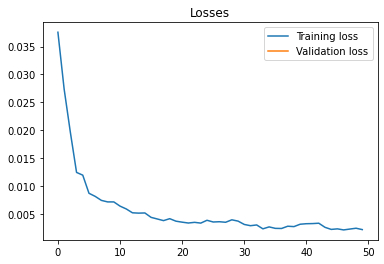

In [ ]:
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = RNNModel(** model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

In [ ]:
def inverse_transform( scaler: sklearn.preprocessing._data.MinMaxScaler, df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """function inverse_transform DataFrame"""
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions: list, values: list, df_test: pd.DataFrame, scaler: sklearn.preprocessing._data.MinMaxScaler)-> pd.DataFrame:
    """DataFrame creation function with predictions"""
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

df_result = format_predictions(predictions, values, X_test, scaler)
df_result

,value,prediction
date,,
2022-08-16,61.374699,67.770561
2022-08-17,61.424698,64.895004
2022-08-18,60.755199,64.681549
2022-08-19,59.957001,60.580307
2022-08-20,59.132099,57.253830
2022-08-23,59.741898,58.929508
2022-08-24,59.896301,57.994610
2022-08-25,59.997402,57.775475
2022-08-26,59.769897,58.020943


In [ ]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df: pd.DataFrame) -> dict:
    """Function calculate metrics value and predictions"""
    result_metrics = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
                      'r2' : r2_score(df.value, df.prediction)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])   #средняя абсолютная ошибка
    print("Root Mean Squared Error:   ", result_metrics["rmse"])  #средняя квадратичная ошибка
    print("R^2 Score:                 ", result_metrics["r2"])    # КФ
    return result_metrics

result_metrics = calculate_metrics(df_result)

Mean Absolute Error:        6.1050835
Root Mean Squared Error:    6.857393226139957
R^2 Score:                  -17.652164089740054


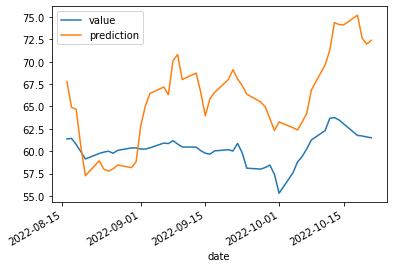

In [ ]:
df_result.plot()

In [ ]:
def comparison(df_result: pd.DataFrame, month: int, year: int) -> None:
    """function comparison of a predicate and a DataSet"""

    dictionary = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    if (month < 10): month = "0" + str(month)
    data1 = str(str(year) + "-" + month + "-" + "01")
    data2 = str(str(year) + "-" + month + "-" + str(dictionary[int(month) - 1]))

    df_result = df_result.loc[(df_result["date"] >= datetime.strptime(data1, "%Y-%m-%d")) & (df_result["date"] <= datetime.strptime(data2, "%Y-%m-%d"))]

    fig = plt.figure(figsize=(10, 5))
    plt.title("Value by month")  
    df_result = df_result.set_index(['date'])
    plt.xlabel("Day")
    plt.ylabel("value")
    plt.plot(df_result['value'], color="blue", marker="x", linewidth=2, markersize=4)
    plt.plot(df_result['prediction'], color="orange", marker="x", linewidth=2, markersize=4)

    plt.legend(["Temp", "Prediction temp"])
    plt.show()